# K-Means Exploration (ACS PUMS Persons)

This notebook loads the `persons_master.csv`, preprocesses features, and runs K-means-style clustering to explore structure in the data.

It includes:
- **Row clustering** (households/people) with **MiniBatchKMeans** using a mixed numeric+categorical pipeline.
- **Feature (variable) clustering** for numeric variables using correlations (optional, but useful for “how variables relate to each other”).

In [9]:

# Imports
import os
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt


In [10]:

# Config (match paths used in 2_EDA_master.ipynb)
DATA_PATH = "../1_Raw_Data/data_persons_ca_1yr/persons_master.csv"
TARGET = "POVPIP"   # optional to drop for clustering
OUTPUT_DIR = "kmeans_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Sampling (KMeans can be expensive on large N)
SAMPLE_N = 50000     # set None to use all rows
RANDOM_STATE = 42

print("DATA_PATH:", DATA_PATH)
print("OUTPUT_DIR:", OUTPUT_DIR)


DATA_PATH: ../1_Raw_Data/data_persons_ca_1yr/persons_master.csv
OUTPUT_DIR: kmeans_outputs


In [11]:
import pandas as pd

DATA_PATH = "../1_Raw_Data/data_persons_ca_1yr/persons_master.csv"

# Read only header to decide columns
cols = pd.read_csv(DATA_PATH, nrows=0).columns

drop_prefixes = ("PWG", "F")  # weights + allocation flags
drop_exact = {"RT", "SERIALNO", "SPORDER", "POVPIP"}

usecols = [c for c in cols if not c.startswith(drop_prefixes) and c not in drop_exact]

df = pd.read_csv(DATA_PATH, usecols=usecols)
print("Shape:", df.shape)
df.head()


Shape: (1842394, 114)


,DIVISION,PUMA,REGION,ADJINC,AGEP,CIT,CITWP,COW,DDRS,DEAR,...,RACSOR,RACWHT,RC,SCIENGP,SCIENGRLP,SFN,SFR,SOCP,WAOB,year
0,9,3701,4,1013097,30,1,NaN,6.0,2.0,2,...,1,0,NaN,NaN,NaN,NaN,NaN,537061,1,2018
1,9,3755,4,1013097,69,1,NaN,NaN,2.0,2,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,2018
2,9,7319,4,1013097,25,1,NaN,NaN,1.0,1,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,2018
3,9,6511,4,1013097,31,1,NaN,NaN,2.0,2,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,2018
4,9,101,4,1013097,19,5,NaN,1.0,2.0,2,...,0,0,NaN,NaN,NaN,NaN,NaN,272022,4,2018


In [12]:

# Drop columns we don't want to cluster on (IDs, weights, allocation flags)
def is_useless(col: str) -> bool:
    if col.startswith("PWG"):      # person weights + replicates
        return True
    if col.startswith("F"):        # allocation flags
        return True
    if col in ["RT", "SERIALNO", "SPORDER"]:  # identifiers
        return True
    return False

drop_cols = [c for c in df.columns if is_useless(c)]
if TARGET in df.columns:
    drop_cols.append(TARGET)

X_df = df.drop(columns=drop_cols, errors="ignore").copy()
print("Dropped:", len(drop_cols))
print("Remaining features:", X_df.shape[1])


Dropped: 0
Remaining features: 114


In [13]:

# Optional: sample rows (recommended for speed)
if SAMPLE_N is not None and len(X_df) > SAMPLE_N:
    X_df = X_df.sample(n=SAMPLE_N, random_state=RANDOM_STATE)
    df_sample = df.loc[X_df.index].copy()
else:
    df_sample = df.loc[X_df.index].copy()

print("Using rows:", X_df.shape[0])


Using rows: 50000


In [14]:

# Identify numeric vs categorical features.
# NOTE: ACS columns are often integer-coded categories. This heuristic treats low-cardinality numeric columns as categorical.
cat_cols = []
num_cols = []

for c in X_df.columns:
    s = X_df[c]
    if s.dtype == "object":
        cat_cols.append(c)
    else:
        # numeric-coded categorical if small number of unique values
        nunq = s.nunique(dropna=True)
        if nunq <= 50:
            cat_cols.append(c)
        else:
            num_cols.append(c)

print("Numeric:", len(num_cols))
print("Categorical:", len(cat_cols))
print("Example numeric:", num_cols[:10])
print("Example categorical:", cat_cols[:10])


Numeric: 30
Categorical: 84
Example numeric: ['PUMA', 'AGEP', 'CITWP', 'INTP', 'JWMNP', 'MARHYP', 'OIP', 'PAP', 'RETP', 'SEMP']
Example categorical: ['DIVISION', 'REGION', 'ADJINC', 'CIT', 'COW', 'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY']


In [15]:

# Preprocessing pipeline
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3,  # keep sparse if many one-hot columns
)

preprocess


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['PUMA', 'AGEP', 'CITWP', 'INTP', 'JWMNP',
                                  'MARHYP', 'OIP', 'PAP', 'RETP', 'SEMP',
                                  'SSIP', 'SSP', 'WAGP', 'WKHP', 'YOEP',
                                  'ANC1P', 'ANC2P', 'INDP', 'JWAP', 'JWDP',
                                  'LANP', 'MIGPUMA', 'MIGSP', 'OCCP', 'PERNP',
                                  'PINCP', 'POBP', 'POWPUMA', 'RAC2P',
                                  'RA...
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['DIVISION', 'REGION', 'ADJINC', 'CIT', 'COW',
                                  'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY',
                                  'DRAT', 'DRATX', 'DREM', 'ENG', 'GCL', 'GCM',
                                  'GCR', 'HINS1', 'HINS2', 'HINS3', 'HINS4',
                                  'HINS5', 'HINS6', 'HINS7', 'JWRIP', 'LANX',
                                  'MAR', 'MARHD', 'MARHM', 'MARHT', ...])])

In [16]:

# Transform once (on sample) for model selection
X = preprocess.fit_transform(X_df)

X.shape


/opt/conda/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['ESP' 'NOP']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


(50000, 1198)

k= 3  inertia=2,317,407  silhouette=0.0700
k= 5  inertia=2,182,174  silhouette=0.0644
k= 8  inertia=2,057,300  silhouette=0.0442
k=10  inertia=1,988,198  silhouette=0.0468
k=12  inertia=1,922,392  silhouette=0.0539


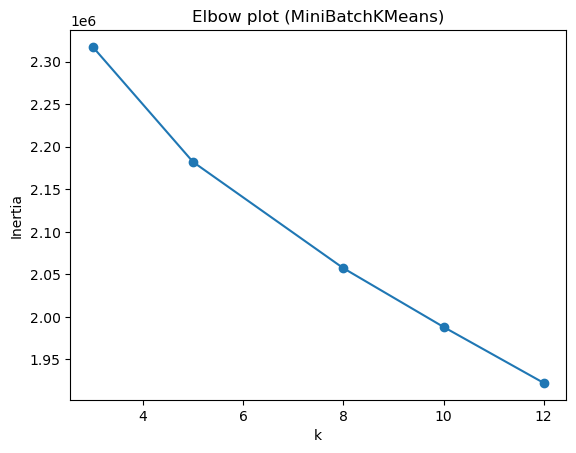

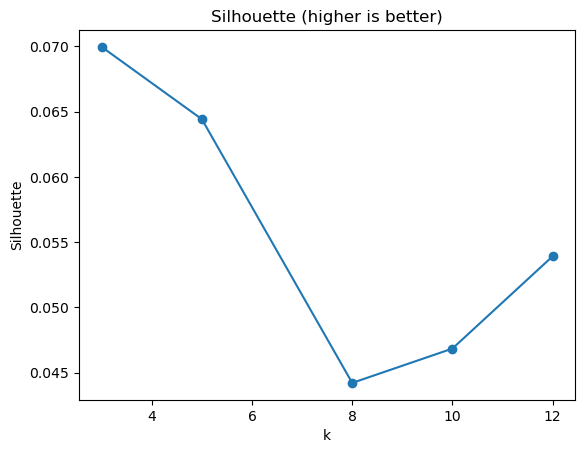

Best k by silhouette: 3


In [17]:

# Choose K using inertia + silhouette (on a smaller subsample for silhouette)
k_list = [3, 5, 8, 10, 12]
inertias = []
silhouettes = []

# further subsample for silhouette if needed
sil_n = min(15000, X.shape[0])
rng = np.random.default_rng(RANDOM_STATE)
sil_idx = rng.choice(X.shape[0], size=sil_n, replace=False)
X_sil = X[sil_idx]

for k in k_list:
    km = MiniBatchKMeans(
        n_clusters=k,
        random_state=RANDOM_STATE,
        batch_size=4096,
        n_init="auto",
        max_iter=200,
    )
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)

    # silhouette can be expensive; run on X_sil using the same model's labels for those rows
    sil = silhouette_score(X_sil, labels[sil_idx], metric="euclidean")
    silhouettes.append(sil)
    print(f"k={k:>2}  inertia={km.inertia_:,.0f}  silhouette={sil:.4f}")

# Plot
plt.figure()
plt.plot(k_list, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow plot (MiniBatchKMeans)")
plt.show()

plt.figure()
plt.plot(k_list, silhouettes, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("Silhouette (higher is better)")
plt.show()

best_k = int(k_list[int(np.argmax(silhouettes))])
print("Best k by silhouette:", best_k)


In [18]:

# Fit final model
k = best_k  # or set manually
final_km = MiniBatchKMeans(
    n_clusters=k,
    random_state=RANDOM_STATE,
    batch_size=4096,
    n_init="auto",
    max_iter=300,
)
clusters = final_km.fit_predict(X)

df_sample["cluster"] = clusters
df_sample["cluster"].value_counts().sort_index()


cluster
0    23309
1    14747
2    11944
Name: count, dtype: int64

In [19]:

# Save clustered sample (so you can use it later for feature engineering / profiling)
out_csv = os.path.join(OUTPUT_DIR, f"persons_master_sample_with_clusters_k{k}.csv")
df_sample.to_csv(out_csv, index=False)
out_csv


'kmeans_outputs/persons_master_sample_with_clusters_k3.csv'

In [20]:

# Quick cluster profiling (numeric features only)
# Shows which numeric features differ most across clusters (mean values).
if len(num_cols) > 0:
    prof = df_sample[num_cols + ["cluster"]].groupby("cluster").mean(numeric_only=True)
    # rank features by between-cluster variance
    var_rank = prof.var(axis=0).sort_values(ascending=False)
    top_feats = var_rank.head(20).index.tolist()
    display(prof[top_feats].round(3))
else:
    print("No numeric columns identified by heuristic; adjust the heuristic above if needed.")


,PERNP,WAGP,PINCP,RETP,SSP,INTP,SEMP,RAC2P,OCCP,OIP,SSIP,INDP,MIGPUMA,LANP,POWPUMA,PUMA,ANC2P,POBP,ANC1P,PAP
cluster,,,,,,,,,,,,,,,,,,,,
0,81427.318,76269.053,86638.292,913.208,328.912,3391.286,5158.265,656.322,3378.778,479.871,33.373,6713.845,5413.748,1889.483,5654.678,5586.421,796.415,68.347,511.062,64.323
1,3277.230,2608.403,38227.982,12446.896,10405.585,9492.069,668.827,865.206,3909.812,1509.083,993.890,6799.393,5030.120,1775.375,5691.254,5587.481,807.272,86.176,447.560,103.228
2,27543.419,25874.097,29578.828,520.548,368.688,377.209,1669.323,3621.543,5386.404,515.809,120.353,5963.101,4685.512,1321.497,5301.169,5285.884,935.069,165.454,438.161,132.801


## Optional: Cluster the *variables* (numeric) using correlation

If what you want is *“which variables move together”*, clustering the **features** can be more direct than clustering people/rows.

Below we compute a correlation matrix over numeric variables, convert it to a feature embedding, and run KMeans to group variables with similar correlation profiles.

In [21]:

# Build variable clusters for numeric variables only
# (Skip if there are too few numeric columns.)
if len(num_cols) >= 5:
    # impute numeric-only for correlation
    num_data = df_sample[num_cols].copy()
    num_data = num_data.fillna(num_data.median(numeric_only=True))

    # standardize
    Z = (num_data - num_data.mean()) / (num_data.std(ddof=0) + 1e-9)
    corr = np.corrcoef(Z.to_numpy().T)
    corr = np.nan_to_num(corr, nan=0.0)

    # Each variable represented by its correlations with all other variables
    # (Optionally scale; corr is already bounded)
    # Choose k for variables a bit smaller
    var_k = min(12, max(3, int(np.sqrt(len(num_cols)))))
    var_km = KMeans(n_clusters=var_k, random_state=RANDOM_STATE, n_init="auto")
    var_labels = var_km.fit_predict(corr)

    var_clusters = pd.DataFrame({"variable": num_cols, "var_cluster": var_labels})
    var_clusters = var_clusters.sort_values(["var_cluster", "variable"]).reset_index(drop=True)

    out_vars = os.path.join(OUTPUT_DIR, f"numeric_variable_clusters_k{var_k}.csv")
    var_clusters.to_csv(out_vars, index=False)

    print("Saved:", out_vars)
    display(var_clusters.head(30))
else:
    print("Not enough numeric columns for correlation-based variable clustering.")


Saved: kmeans_outputs/numeric_variable_clusters_k5.csv


,variable,var_cluster
0,AGEP,0
1,INDP,0
2,RETP,0
3,SSP,0
4,ANC1P,1
5,ANC2P,1
6,JWAP,1
7,JWDP,1
8,JWMNP,1
9,LANP,1


In [22]:
# 1) Create the same sample df you used for X_processed
df_sample = df.sample(n=50000, random_state=42).copy()

# 2) Fit KMeans on the processed version of *that* df_sample
X_processed = preprocess.fit_transform(df_sample)

clusters = kmeans.fit_predict(X_processed)

# 3) Attach clusters to the sample
df_sample["cluster"] = clusters

# Now this works:
df_sample.groupby("cluster")["POVPIP"].mean()


/opt/conda/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['ESP' 'NOP']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


NameError: name 'kmeans' is not defined

In [ ]:
df.groupby("cluster")["POVPIP"].mean()

# (Optional) Inspect a single variable-cluster's correlations as a quick sanity check
if 'var_clusters' in globals():
    c = int(var_clusters["var_cluster"].mode()[0])
    vars_in = var_clusters.loc[var_clusters["var_cluster"]==c, "variable"].tolist()
    print(f"Example var_cluster={c} size={len(vars_in)}")
    # show the within-cluster correlation submatrix
    idx = [num_cols.index(v) for v in vars_in]
    sub = corr[np.ix_(idx, idx)]
    sub_df = pd.DataFrame(sub, index=vars_in, columns=vars_in)
    display(sub_df.round(2).iloc[:15, :15])
